# Gru GAN 1024

## Import

In [3]:
import argparse
import os
import numpy as np
import math
import pickle
import cv2 as cv
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.autograd import Variable
from torch.cuda.amp import autocast, GradScaler

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision

## Hyperparameters

In [4]:
n_epochs = 100 # type=int, "number of epochs of training"
batch_size = 8 # type=int, "size of the batches"

lr = 0.002 # type=float "adam: learning rate"
b1 = 0.9 # type=float "adam: decay of first order momentum of gradient"
b2 = 0.999 # type=float "adam: decay of first order momentum of gradient"

num_gpu = 2 
cuda = torch.cuda.is_available()

latent_dim = 4 # type=int "dimensionality of the latent space"
img_size = 1024 # type=int "size of each image dimension"
channels = 1 # type=int "number of image channels"
sample_interval = 10000 # int "interval betwen image samples"

FLenTar = 100

dataset_dir = r"C:\Users\Leo's PC\Documents\SSTP Tests\stylegan2-ada-pytorch\Font1024"

## Datasets

In [5]:
class Dataset(Dataset):

    def __init__(self, file_dir, transform=None):

        self.dir = file_dir
        self.transform = transform
        self.diction = {}
        
        idx = 0
        for filename in os.listdir(self.dir):
            if filename.endswith('png'):
                self.diction[idx] = filename
                idx += 1
                        
    def __len__(self):
        return len(self.diction) - 1

    
    def __getitem__(self, idx):
        x, y = self.diction[idx], self.diction[idx + 1]
        directory_x, directory_y = self.dir + "\\" + str(x), self.dir + "\\" + str(y)
        x, y = cv.imread(directory_x, cv.IMREAD_GRAYSCALE), cv.imread(directory_y, cv.IMREAD_GRAYSCALE)
        if self.transform:
            x, y = self.transform(x), self.transform(y)
        return x, y
    

# dataset = Dataset(file_dir=dataset_dir)

## Dataloaders

In [6]:
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)

NameError: name 'dataset' is not defined

## Model classes

In [55]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        #expected inout size (N, 3, 256, 128)
        
        #=======
        #Encoder
        #=======
        
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=[3,3], stride=1, padding=1)
        self.activation1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[3,3], stride=1, padding=1)
        self.activation1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=[3,3], stride=1, padding=1)
        self.activation2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=[3,3], stride=1, padding=1)
        self.activation2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=[3,3], stride=1, padding=1)
        self.activation3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=[3,3], stride=2, padding=1)
        self.activation3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=[3,3], stride=1, padding=1)
        self.activation3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=2, padding=1)
        self.activation4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation5_1 = nn.ReLU()      
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=2, padding=1)
        self.activation5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation5_3 = nn.ReLU()
        
        #size = (N, 512, 4, 2)
        
        #=======
        #Recurrent Module
        #=======
        
        self.pool_r = nn.AdaptiveMaxPool2d(output_size = (2, 1))
        
        #size of GRU input = (batch_size, seq_len, inp_size)
        self.gru = nn.GRU(input_size=1024, hidden_size=1024, num_layers=2, bias=True, batch_first=True, dropout=0.2)
        
        self.upsample_r = nn.Upsample(size=(8, 4))
        
        #=======
        #Decoder
        #=======
        
        #size = (N, 512, 8, 4)
        
        self.conv6_1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation6_1 = nn.ReLU()
        self.conv6_2 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation6_2 = nn.ReLU()
        self.conv6_3 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation6_3 = nn.ReLU()
        self.upsample6 = nn.Upsample(scale_factor=2)
        
        self.conv7_1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation7_1 = nn.ReLU()
        self.conv7_2 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation7_2 = nn.ReLU()
        self.conv7_3 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation7_3 = nn.ReLU()
        self.upsample7 = nn.Upsample(scale_factor=2)
        
        self.conv8_1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=[3,3], stride=1, padding=1)
        self.activation8_1 = nn.ReLU()
        self.conv8_2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=[3,3], stride=1, padding=1)
        self.activation8_2 = nn.ReLU()
        self.conv8_3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=[3,3], stride=1, padding=1)
        self.activation8_3 = nn.ReLU()
        self.upsample8 = nn.Upsample(scale_factor=2)
        
        self.conv9_1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=[3,3], stride=1, padding=1)
        self.activation9_1 = nn.ReLU()
        self.conv9_2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=[3,3], stride=1, padding=1)
        self.activation9_2 = nn.ReLU()
        self.upsample9 = nn.Upsample(scale_factor=2)
        
        self.conv10_1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=[3,3], stride=1, padding=1)
        self.activation10_1 = nn.ReLU()
        self.conv10_2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=[3,3], stride=1, padding=1)
        self.activation10_2 = nn.ReLU()
        
        self.output = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=[1,1], stride=1, padding=0)
        self.activation_output = nn.Sigmoid()
        
        self.h = torch.Tensor(np.random.randn(2, 2, 1024)) #(num_layers, batchsize, inp.shape)
        

    def forward(self,x):
        
        #=======
        #Encoder
        #=======
        
        x = self.conv1_1(x)
        x = self.activation1_1(x)
        x = self.conv1_2(x)
        x = self.activation1_2(x)
        x = self.pool1(x)
        
        x = self.conv2_1(x)
        x = self.activation2_1(x)
        x = self.conv2_2(x)
        x = self.activation2_2(x)
        x = self.pool2(x)
        
        x = self.conv3_1(x)
        x = self.activation3_1(x)
        x = self.conv3_2(x)
        x = self.activation3_2(x)
        x = self.conv3_3(x)
        x = self.activation3_3(x)
        x = self.pool3(x)
        
        x = self.conv4_1(x)
        x = self.activation4_1(x)
        x = self.conv4_2(x)
        x = self.activation4_2(x)
        x = self.conv4_3(x)
        x = self.activation4_3(x)
        x = self.pool4(x)
        
        x = self.conv5_1(x)
        x = self.activation5_1(x)       
        x = self.conv5_2(x)
        x = self.activation5_2(x)
        x = self.conv5_3(x)
        x = self.activation5_3(x)
        
        #=======
        #Recurrent Module
        #=======
        
        
        x = self.pool_r(x)
        
        x = x.view(x.shape[0], -1)
        x = torch.unsqueeze(x, 1)
        
        x, self.h = self.gru(x, self.h)
        
        x = x[:,-1]
        x = torch.reshape(x, (x.shape[0], 512, 2, 1))
        
        x = self.upsample_r(x)
        
        #=======
        #Decoder
        #=======
        
        x = self.conv6_1(x)
        x = self.activation6_1(x)
        x = self.conv6_2(x)
        x = self.activation6_2(x)
        x = self.conv6_3(x)
        x = self.activation6_3(x)
        x = self.upsample6(x)
        
        x = self.conv7_1(x)
        x = self.activation7_1(x)
        x = self.conv7_2(x)
        x = self.activation7_2(x)
        x = self.conv7_3(x)
        x = self.activation7_3(x)
        x = self.upsample7(x)
        
        x = self.conv8_1(x)
        x = self.activation8_1(x)
        x = self.conv8_2(x)
        x = self.activation8_2(x)
        x = self.conv8_3(x)
        x = self.activation8_3(x)
        x = self.upsample8(x)
        
        x = self.conv9_1(x)
        x = self.activation9_1(x)
        x = self.upsample9(x)
        x = self.conv9_2(x)
        x = self.activation9_2(x)
        x = self.upsample9(x)
        
        x = self.conv10_1(x)
        x = self.activation10_1(x)
        x = self.conv10_2(x)
        x = self.activation10_2(x)
        
        x = self.output(x)
        x = self.activation_output(x)
        
        return x
    
    
    def name(self):
        return "Generator"
    
    
    def load_SalGan_weights(self, pretrained_weights='gen_modelWeights0090.npz'):
        
        self.pretrained_weights = np.load(open(pretrained_weights, 'rb'), allow_pickle=True)
        
        self.layers = [module for module in self.modules() if type(module) != nn.Sequential]
        self.conv_layers = [conv for conv in self.layers if type(conv) == nn.modules.conv.Conv2d or type(conv) == nn.modules.conv.ConvTranspose2d]

        array_idx = 0
        for layer in self.conv_layers:

            if type(layer) == nn.modules.conv.ConvTranspose2d:
                #the dim order of weight shape is messed up for ConvTranspose, so do transpose before loading

                self.reshaped_array = self.pretrained_weights['arr_' + str(array_idx)].transpose(1, 0, 2, 3)

                if layer.weight.shape == self.reshaped_array.shape:
                    layer.weight = nn.Parameter(torch.from_numpy(self.reshaped_array).float())
                else:
                    print("One layer was initialized with Xavier due to shape mismatch")
                    torch.nn.init.xavier_uniform_(layer.weight)           
                
                array_idx += 1  #add 1 to idx to fetch the next element from the file

                self.reshaped_array = self.pretrained_weights['arr_' + str(array_idx)]
                
                if layer.bias.shape == self.reshaped_array.shape:
                    layer.bias = nn.Parameter(torch.from_numpy(self.reshaped_array.copy()).float())
                else:
                    layer.bias.data.fill_(0.01)

            else: 
                layer.weight = nn.Parameter(torch.from_numpy(self.pretrained_weights['arr_' + str(array_idx)]).float())

                array_idx += 1  #add 1 to idx to fetch the next element from the file

                layer.bias = nn.Parameter(torch.from_numpy(self.pretrained_weights['arr_' + str(array_idx)]).float())

            array_idx += 1 #add 1 to idx to fetch the next element from the file
    
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.ResNet = torchvision.models.densenet121(pretrained=True)
        self.ResNet.fc = nn.Linear(in_features=1000, out_features=1000, bias=True)
        
        self.gru = nn.GRU(input_size=1000, hidden_size=512, num_layers=3, bias=True, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(512, 2, bias=True)
        
        self.softmax = nn.Softmax(dim=1)

    @autocast()
    def forward(self, x):
        
        try:
            self.h
        except:
            self.h = torch.Tensor(np.random.randn(3, x.shape[0], 512)).cuda() #(num_layers, batchsize, inp.shape)
        
        x = self.ResNet(x)
        x = torch.unsqueeze(x, 1)
        x, self.h = self.gru(x, self.h)
        x = x[:,-1]
        x = self.fc(x)
        x = self.softmax(x)

        return x
    
    
    def name(self):
        return "Discriminator"
    
    
class StyleGanGenerator(nn.Module):
    def __init__(self):
        super(StyleGanGenerator, self).__init__()
        
        self.ResNet = torchvision.models.densenet121(pretrained=True)
        self.ResNet.fc = nn.Linear(in_features=1000, out_features=1000, bias=True)
            
        self.gru = nn.GRU(input_size=1000, hidden_size=512, num_layers=3, bias=True, batch_first=True, dropout=0.2)
        
        with open('ffhq256.pkl', 'rb') as f:
            self.StyleGan = pickle.load(f)['G_ema'].cuda() 
        
    @autocast()    
    def forward(self, x):
        try:
            self.h
        except:
            self.h = torch.Tensor(np.random.randn(3, x.shape[0], 512)).cuda() #(num_layers, batchsize, inp.shape)

        ## ENCODER
        x = self.ResNet(x)
        
        ## GRU
        x = torch.unsqueeze(x, 1)
        x, self.h = self.gru(x, self.h)
        x = torch.squeeze(x, 1)
        print(x.shape)
        
        ## DECODER
        x = self.StyleGan(x, None)
        
        return x
        
    
    def name(self):
        return "StyleGanGenerator"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


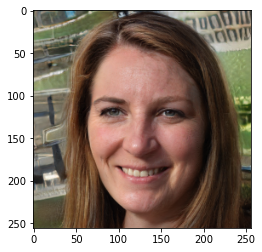

In [56]:
with open('ffhq256.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
    
z = torch.randn([1, 512]).cuda()    # latent codes
c = None                                # class labels (not used in this example)
img = G(z, c)
img_manipulated = (img + 1) / 2

plt.imshow((np.array(torch.squeeze(img_manipulated, 0).cpu()).transpose(1, 2, 0)))

In [57]:
G = StyleGanGenerator().cuda()
D = Discriminator().cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 512])
torch.Size([1, 3, 256, 256])
tensor([[0.4288, 0.5712]], device='cuda:0', grad_fn=<SoftmaxBackward>)


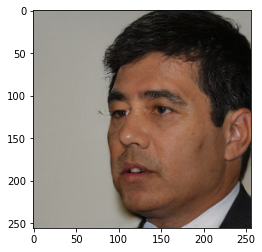

In [59]:
inp = torch.Tensor(np.random.randn(2, 3, 256, 256)).cuda()
out = G(img)
print(out.shape)
D_out = D(out)
print(D_out)
plt.imshow((torch.squeeze((out[0] + 1) / 2, 0).cpu().detach().numpy()).transpose(1, 2, 0))

## Loss, Optimizer, Training setup

In [6]:
# Loss function
adversarial_loss = torch.nn.BCEWithLogitsLoss()


# Initialize generator and discriminator
G = Generator()
D = Discriminator()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


G.cuda()
D.cuda()
adversarial_loss.cuda()


G = torch.nn.DataParallel(G)
D = torch.nn.DataParallel(D)


optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(b1, b2))

scaler = GradScaler()

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

G.apply(init_weights)
D.apply(init_weights)

## Training

### Intuition
The Generator takes an input frame x, outputs a fake frame y_hat. If we calculate the loss and back_prop now, we are training a Generator that can predict the next frame. If a sequence of mutiple fake frames is desired during inference, we then feed the Generator y_hat as the input and get the next frame. However, here's a problem: during training, the model only learns how to produce a fake frame based on a real frame. If we want to countinuously feed the model hundreds of  fake frames, the quality of the output will deteriorate quickly.

Therefore, we train the model in a way that it's loss is judged based on the whole sequence, not just the next frame. In a sense, this trains the model in a setup that is closer to its use-case senerio. However, keep in mind that the video is still generated by passing in fake(t-1) to get fake(t), in a loop.

We propose a length scheduler that automatically determines the length of the output sequence based on which the generator will be judged. The generator will start with learning how to predict the next frame. When it gets good at it, it will learn to generate 2 frames, untill the target value is hit.

In [ ]:
y_hat_list = []
y_list = []
rating = 0
    
for i, x, y in enumerate(dataloader):
    
    with autocast():
        y_hat = G(x)
        
    y_hat_list = np.append(y_hat_list, y_hat)
    
    ## Evaluation and backprop
    
    if scheduler(i, loss, len(y_hat_list)): #returns True if it approves of evaluation
        
        ## ========================
        ## Train the Generator
        ## ========================
        
        D.clear_mem()
        
        with autocast():
            for fake in y_hat_list:           
                rating = D(fake)
            
            ad_loss = loss_function(rating, 1)
            gt_loss = loss_fuction(y_hat, y)

            g_loss = 0.7 * ad_loss + 0.3 * gt_loss
        
        scaler.scale(g_loss).backward()
        scaler.step(optimizer_G) 
        scaler.update()
        
        y_hat_list = []
        y_list = []
        x_list = []
        
        G.clear_mem()
        
        ## ========================
        ## Train the Discriminator
        ## ========================
        
        D.clear_mem()
        
        with autocast():
            rating = D(x)
            for y_hat in y_hat_list:           
                rating = D(y_hat)
            fake_loss = loss_function(rating, 0)
        
            D.clear_mem()
            
            rating = D(x)
            for y in y_list:
                rating = D(y)
            real_loss = loss_function(rating, 1)

            d_loss = 0.5 * real_loss + 0.5 * fake_loss
        
        scaler.scale(d_loss).backward()
        scaler.step(optimizer_D) 
        scaler.update()
        
        
    print()

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


for epoch in range(n_epochs):
    
    for idx, imgs in enumerate(loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 2).fill_(1.0), requires_grad=False).cuda()
        fake = Variable(Tensor(imgs.shape[0], 2).fill_(0.0), requires_grad=False).cuda()

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).cuda().to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        latent_vector = Variable(Tensor(np.random.randn(imgs.shape[0], 512, latent_dim, latent_dim))).cuda()
        
        G.train()
        D.eval()
        
        with autocast():
            gen_imgs = G(latent_vector) # Generate a batch of images
            g_loss = adversarial_loss(D(gen_imgs), valid) # Loss measures generator's ability to fool the discriminator

        scaler.scale(g_loss).backward() #back propagation with calculated loss
        scaler.step(optimizer_G) 
        scaler.update()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        D.train()
        optimizer_D.zero_grad()
        
        real_imgs.unsqueeze_(1)
        
        with autocast():
            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(D(real_imgs), valid)
            fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

        scaler.scale(d_loss).backward() #back propagation with calculated loss
        scaler.step(optimizer_D) 
        scaler.update()

       
        batches_done = epoch * len(loader) + idx
        
        
    save_image(gen_imgs.data[:25], r"C:/Users/Leo's PC/Documents/SSTP Tests/Chinese Characters/LightGAN out/%d.png" % batches_done, nrow=5, normalize=True)
    print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, idx, len(loader), d_loss.item(), g_loss.item()))

C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


[Epoch 0/100] [Batch 3563/3564] [D loss: 0.724080] [G loss: 0.474079]
[Epoch 1/100] [Batch 3563/3564] [D loss: 0.724085] [G loss: 0.474081]
[Epoch 2/100] [Batch 3563/3564] [D loss: 0.724079] [G loss: 0.474079]
[Epoch 3/100] [Batch 3563/3564] [D loss: 0.724083] [G loss: 0.474081]
[Epoch 4/100] [Batch 3563/3564] [D loss: 0.724084] [G loss: 0.474086]
[Epoch 5/100] [Batch 3563/3564] [D loss: 0.724084] [G loss: 0.474077]
[Epoch 6/100] [Batch 3563/3564] [D loss: 0.724077] [G loss: 0.474077]


In [ ]:
'''

checkpoint_file = open(r"C:/Users/Leo's PC/Documents/SSTP Tests/Chinese Characters/LightGAN out/G.tar", 'wb')
torch.save({'model': G.state_dict()}, checkpoint_file)
checkpoint_file.close()

checkpoint = torch.load(open("C:/Users/Leo's PC/Documents/SSTP Tests/Chinese Characters/LightGAN out/G.tar", 'rb'))
G.load_state_dict(checkpoint['model'])

'''